# Threat detection Model- Ensembling LSTM and ANN

### Loading Libraries

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import itertools
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from google.colab import drive
import os
import joblib

In [46]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Dataset

In [47]:
# Load the dataset
ds = pd.read_csv("/content/dataset.csv")

In [48]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [49]:
ds.shape

(25192, 42)

In [50]:
ds.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [51]:
ds.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
ds.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


### Exploratory Data Analysis

In [53]:
# Visualize the class distribution
ds['class'].value_counts()

class
normal     13449
anomaly    11743
Name: count, dtype: int64

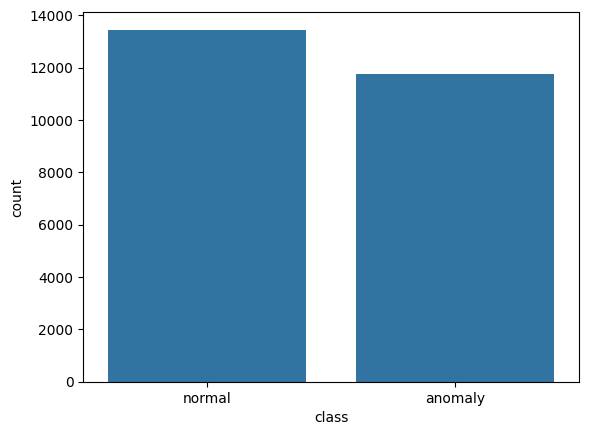

In [54]:
sns.countplot(x=ds['class'])
plt.show()

In [55]:
# Visualize protocol types
ds['protocol_type'].value_counts()

protocol_type
tcp     20526
udp      3011
icmp     1655
Name: count, dtype: int64

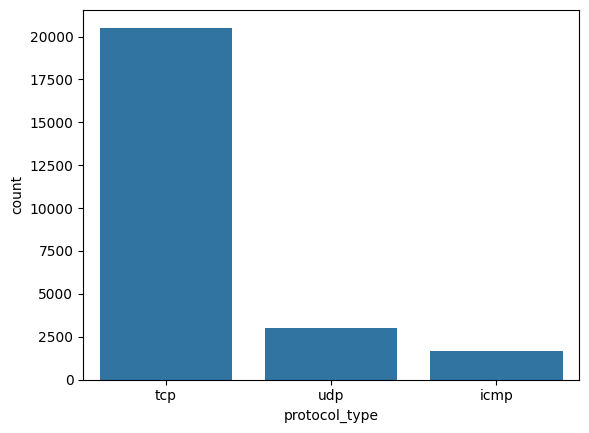

In [56]:
sns.countplot(x=ds['protocol_type'])
plt.show()

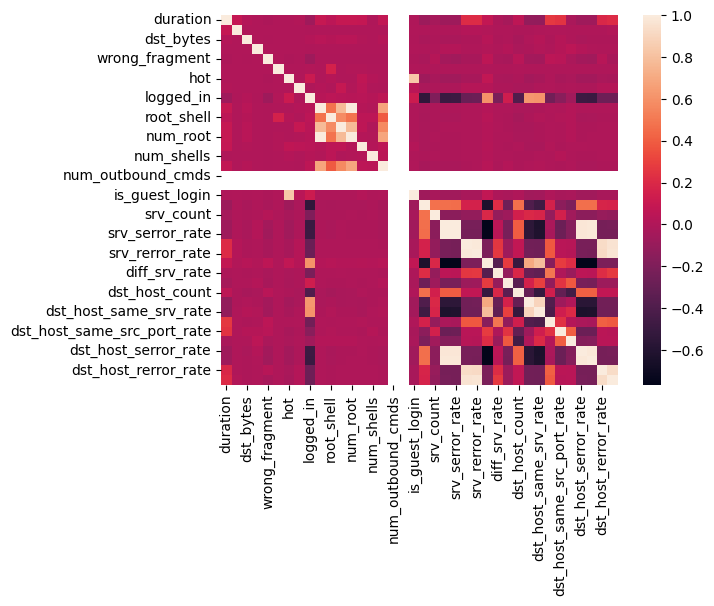

In [57]:
# Heatmap for correlation
sns.heatmap(ds.corr(numeric_only=True))
plt.show()

### Data Preprocessing

In [58]:
ds.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [59]:
ds.duplicated().sum()

0

In [60]:
# Encode categorical features
label_encoder = LabelEncoder()
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = label_encoder.fit_transform(df[col])

In [61]:
le(ds)
(ds.head())

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [62]:
ds.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [63]:
# Feature Selection
X = ds.drop(['class'], axis=1)
y = ds['class']
rfc = RandomForestClassifier()
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X, y)
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X.columns)]
selected_features = [v for i, v in feature_map if i]
top_features = pd.DataFrame({'Features': selected_features})
top_features.index = top_features.index + 1

In [64]:
print(top_features)

                  Features
1            protocol_type
2                  service
3                     flag
4                src_bytes
5                dst_bytes
6                    count
7            same_srv_rate
8            diff_srv_rate
9       dst_host_srv_count
10  dst_host_same_srv_rate


In [65]:
X = X[selected_features]
scale = StandardScaler()
X = scale.fit_transform(X)

In [66]:

# ANN train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# LSTM train-test split
X_trainL, X_testL, y_trainL, y_testL = train_test_split(X, y, test_size=0.2, random_state=42)
X_trainL, X_valL, y_trainL, y_valL = train_test_split(X_trainL, y_trainL, test_size=0.25, random_state=42)

### ANN- Binary Classificaton

In [67]:
# ANN model
model_ann = Sequential()
model_ann.add(Dense(128, input_dim=X_train.shape[1]))
model_ann.add(ReLU())
model_ann.add(BatchNormalization())
model_ann.add(Dense(128))
model_ann.add(ReLU())
model_ann.add(BatchNormalization())
model_ann.add(Dropout(0.2))
model_ann.add(Dense(64))
model_ann.add(ReLU())
model_ann.add(BatchNormalization())
model_ann.add(Dropout(0.2))
model_ann.add(Dense(32))
model_ann.add(ReLU())
model_ann.add(BatchNormalization())
model_ann.add(Dropout(0.2))
model_ann.add(Dense(1, activation='sigmoid'))

In [68]:
#training and compilation
model_ann.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])
history_ann = model_ann.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
473/473 [==============================] - 5s 5ms/step - loss: 0.1546 - accuracy: 0.9466 - val_loss: 0.1072 - val_accuracy: 0.9647
Epoch 2/100
473/473 [==============================] - 2s 4ms/step - loss: 0.1230 - accuracy: 0.9588 - val_loss: 0.1003 - val_accuracy: 0.9633
Epoch 3/100
473/473 [==============================] - 2s 4ms/step - loss: 0.1210 - accuracy: 0.9608 - val_loss: 0.0969 - val_accuracy: 0.9661
Epoch 4/100
473/473 [==============================] - 2s 4ms/step - loss: 0.1141 - accuracy: 0.9624 - val_loss: 0.0997 - val_accuracy: 0.9675
Epoch 5/100
473/473 [==============================] - 2s 5ms/step - loss: 0.1086 - accuracy: 0.9642 - val_loss: 0.0934 - val_accuracy: 0.9669
Epoch 6/100
473/473 [==============================] - 3s 7ms/step - loss: 0.1054 - accuracy: 0.9636 - val_loss: 0.0908 - val_accuracy: 0.9665
Epoch 7/100
473/473 [==============================] - 2s 4ms/step - loss: 0.1041 - accuracy: 0.9649 - val_loss: 0.0913 - val_accuracy: 0.9651

158/158 [==============================] - 0s 2ms/step
Test Accuracy of ANN Model: 98.39253820202421
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2365
           1       0.99      0.98      0.98      2674

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



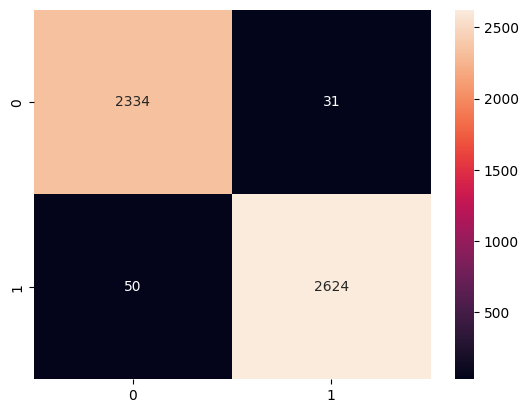

In [69]:
#classification report and
y_pred_ann = model_ann.predict(X_test)
y_pred_ann = (y_pred_ann > 0.5)
accuracy_ann = accuracy_score(y_test, y_pred_ann)
print("Test Accuracy of ANN Model:", accuracy_ann * 100)
print(classification_report(y_test, y_pred_ann))
cm_ann = confusion_matrix(y_test, y_pred_ann)
sns.heatmap(cm_ann, annot=True, fmt="d")
plt.show()

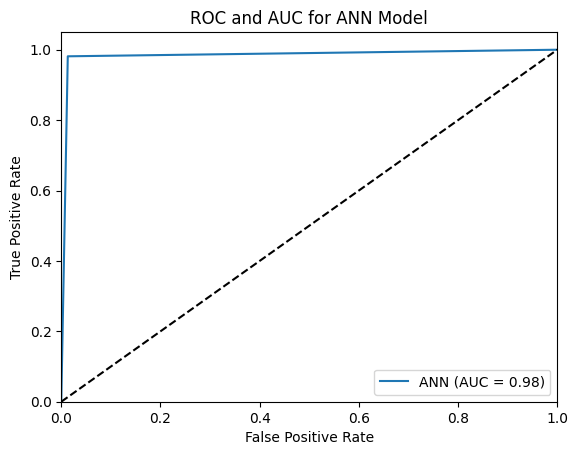

In [70]:

# Calculate ROC and AUC
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred_ann)
auc_ann = roc_auc_score(y_test, y_pred_ann)

# Plot ROC and AUC
plt.figure()
plt.plot(fpr_ann, tpr_ann, label="ANN (AUC = %0.2f)" % auc_ann)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC and AUC for ANN Model")
plt.legend(loc="lower right")
plt.show()


In [71]:
# Save the ANN model
ann_model_path = '/content/drive/My Drive/MyModels/ANN_model.h5'
os.makedirs(os.path.dirname(ann_model_path), exist_ok=True)
model_ann.save(ann_model_path)
print("ANN model saved successfully.")

ANN model saved successfully.


### LSTM

In [72]:
# Reshape the input data for LSTM
X_trainL = np.reshape(X_trainL, (X_trainL.shape[0], X_trainL.shape[1], 1))
X_valL = np.reshape(X_valL, (X_valL.shape[0], X_valL.shape[1], 1))
X_testL = np.reshape(X_testL, (X_testL.shape[0], X_testL.shape[1], 1))

In [73]:
# LSTM model
model_lstm = Sequential([
    LSTM(units=256, return_sequences=True, input_shape=(X_trainL.shape[1], X_trainL.shape[2])),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True),
    Dropout(0.2),
    LSTM(units=64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [74]:
#training and compilation
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm=model_lstm.fit(X_trainL, y_trainL, epochs= 10, batch_size=128, validation_data=(X_valL, y_valL))

Epoch 1/10
119/119 [==============================] - 29s 186ms/step - loss: 0.3599 - accuracy: 0.8658 - val_loss: 0.2009 - val_accuracy: 0.9421
Epoch 2/10
119/119 [==============================] - 22s 189ms/step - loss: 0.1861 - accuracy: 0.9364 - val_loss: 0.1783 - val_accuracy: 0.9327
Epoch 3/10
119/119 [==============================] - 20s 169ms/step - loss: 0.1489 - accuracy: 0.9469 - val_loss: 0.1330 - val_accuracy: 0.9514
Epoch 4/10
119/119 [==============================] - 21s 173ms/step - loss: 0.1316 - accuracy: 0.9539 - val_loss: 0.1336 - val_accuracy: 0.9464
Epoch 5/10
119/119 [==============================] - 25s 214ms/step - loss: 0.1255 - accuracy: 0.9541 - val_loss: 0.1235 - val_accuracy: 0.9498
Epoch 6/10
119/119 [==============================] - 20s 168ms/step - loss: 0.1174 - accuracy: 0.9579 - val_loss: 0.1264 - val_accuracy: 0.9464
Epoch 7/10
119/119 [==============================] - 21s 174ms/step - loss: 0.1164 - accuracy: 0.9571 - val_loss: 0.1188 - val_ac

158/158 [==============================] - 5s 26ms/step
Test Accuracy of LSTM Model: 97.16213534431435
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2365
           1       0.96      0.98      0.97      2674

    accuracy                           0.97      5039
   macro avg       0.97      0.97      0.97      5039
weighted avg       0.97      0.97      0.97      5039



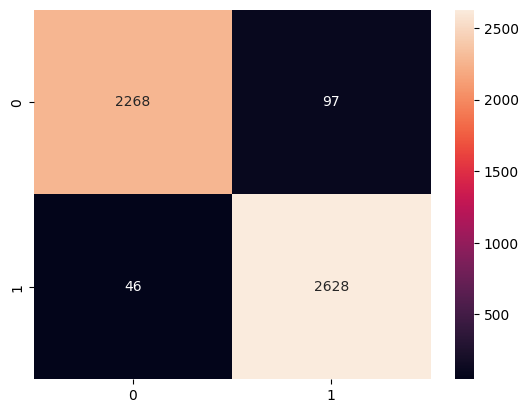

In [75]:
#Classification Report and Confusion  Matrix
y_pred_lstm=model_lstm.predict(X_testL)
y_pred_lstm=(y_pred_lstm> 0.5)
accuracy_lstm=accuracy_score(y_testL, y_pred_lstm)
print("Test Accuracy of LSTM Model:", accuracy_lstm * 100)
print(classification_report(y_testL, y_pred_lstm))
cm_lstm= confusion_matrix(y_testL, y_pred_lstm)
sns.heatmap(cm_lstm, annot= True, fmt="d")
plt.show()

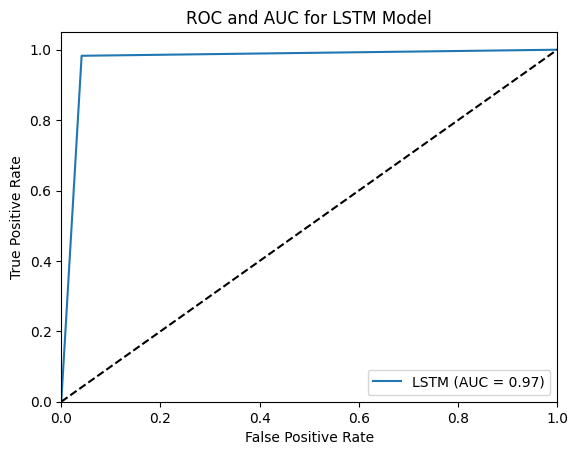

In [76]:
# Calculate ROC and AUC for LSTM model
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_testL, y_pred_lstm)
auc_lstm = roc_auc_score(y_testL, y_pred_lstm)

# Plot ROC and AUC for LSTM model
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, label="LSTM (AUC = %0.2f)" % auc_lstm)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC and AUC for LSTM Model")
plt.legend(loc="lower right")
plt.show()


In [77]:
# Save the LSTM model
lstm_model_path = '/content/drive/My Drive/MyModels/LSTM_model.h5'
os.makedirs(os.path.dirname(lstm_model_path), exist_ok=True)
model_lstm.save(lstm_model_path)
print("LSTM model saved successfully.")

LSTM model saved successfully.


### Ensemble

In [78]:
class EnsembleModel:
    def __init__(self, ann_model_path, lstm_model_path):
        self.model_ann = load_model(ann_model_path)
        self.model_lstm = load_model(lstm_model_path)

    def predict(self, X):
        X_lstm = np.reshape(X, (X.shape[0], X.shape[1], 1))
        y_pred_prob_ann = self.model_ann.predict(X)
        y_pred_prob_lstm = self.model_lstm.predict(X_lstm)
        y_pred_prob_ensemble = (y_pred_prob_ann + y_pred_prob_lstm) / 2
        y_pred_ensemble = (y_pred_prob_ensemble > 0.5).astype(int)
        return y_pred_ensemble

In [79]:
# Save the ensemble model class
ensemble_model = EnsembleModel(ann_model_path, lstm_model_path)
ensemble_model_path = '/content/drive/My Drive/MyModels/ensemble_model.pkl'
os.makedirs(os.path.dirname(ensemble_model_path), exist_ok=True)
with open(ensemble_model_path, 'wb') as f:
    joblib.dump(ensemble_model, f)

In [80]:
# Train the ensemble model for 10 epochs
ensemble_model.model_ann.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
ensemble_model.model_lstm.fit(X_trainL, y_trainL, epochs=5, batch_size=128, validation_data=(X_valL, y_valL))

Epoch 1/10
473/473 [==============================] - 4s 5ms/step - loss: 0.0423 - accuracy: 0.9857 - val_loss: 0.0681 - val_accuracy: 0.9819
Epoch 2/10
473/473 [==============================] - 2s 4ms/step - loss: 0.0432 - accuracy: 0.9851 - val_loss: 0.0577 - val_accuracy: 0.9813
Epoch 3/10
473/473 [==============================] - 2s 5ms/step - loss: 0.0407 - accuracy: 0.9864 - val_loss: 0.1001 - val_accuracy: 0.9839
Epoch 4/10
473/473 [==============================] - 4s 8ms/step - loss: 0.0422 - accuracy: 0.9857 - val_loss: 0.0907 - val_accuracy: 0.9813
Epoch 5/10
473/473 [==============================] - 2s 5ms/step - loss: 0.0403 - accuracy: 0.9864 - val_loss: 0.0632 - val_accuracy: 0.9845
Epoch 6/10
473/473 [==============================] - 2s 4ms/step - loss: 0.0398 - accuracy: 0.9862 - val_loss: 0.0634 - val_accuracy: 0.9845
Epoch 7/10
473/473 [==============================] - 2s 5ms/step - loss: 0.0402 - accuracy: 0.9863 - val_loss: 0.0937 - val_accuracy: 0.9847
Epoch 

158/158 [==============================] - 5s 22ms/step
Test Accuracy of Ensemble Model: 98.27346695772971
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2365
           1       0.99      0.98      0.98      2674

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



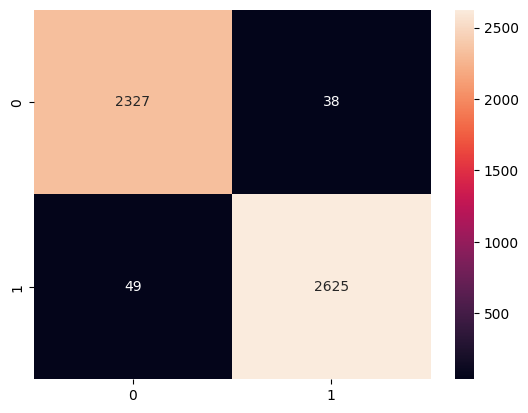

In [81]:
# Predict on the test set
y_pred_ensemble = ensemble_model.predict(X_test)

# Calculate the test accuracy
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print("Test Accuracy of Ensemble Model:", accuracy_ensemble * 100)

# Print the classification report
print(classification_report(y_test, y_pred_ensemble))

# Plot the confusion matrix
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt="d")
plt.show()


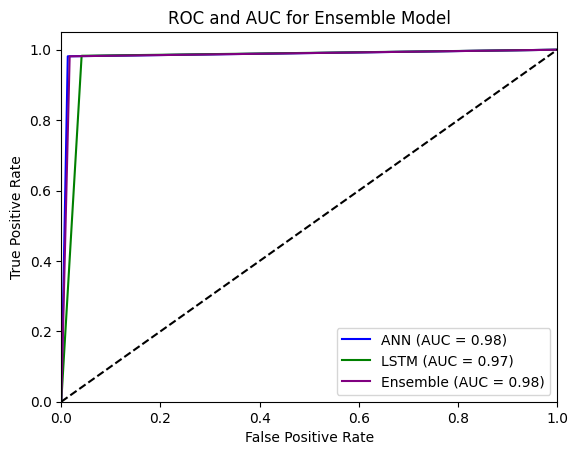

In [82]:
#AUC- ROC Curve
# Plot the ROC and AUC for the ensemble model
plt.figure()
plt.plot(fpr_ann, tpr_ann, label="ANN (AUC = %0.2f)" % auc_ann, color='blue')
plt.plot(fpr_lstm, tpr_lstm, label="LSTM (AUC = %0.2f)" % auc_lstm, color='green')
plt.plot(fpr_ensemble, tpr_ensemble, label="Ensemble (AUC = %0.2f)" % auc_ensemble, color='purple')
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC and AUC for Ensemble Model")
plt.legend(loc="lower right")
plt.show()
